In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

import numpy as np

#### this function builds a Quantum Fourier Transform gate
(this should be doable with a qiskit library too, but I couldn't convert later circuits to gate that way)

In [2]:
def QuantumFourierTransform(digits: int):
    
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegY)

    for i, q in enumerate(QRegY):
        QC.h(q)

        theta = np.pi / 2
        for r in QRegY[i + 1:]:
            QC.cp(theta, r, q)
            theta /= 2
    
    for i in range(digits // 2):
        QC.swap(QRegY[i],QRegY[- (i + 1)])
    
    return QC.to_gate()

#### the following function builds a oracle, $U_C$, such that $U_C | x \rangle | y \rangle = | x \rangle | y - C (x) \rangle$

In [3]:
def EnergyOracle(GraphLaplacian: list[list[int]], digits: int):

    QRegX = QuantumRegister(len(GraphLaplacian))
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegX, QRegY)

    QFT = QuantumFourierTransform(digits)
    QC.append(QFT, QRegY)
    
    # Phasers
    for i, v in enumerate(GraphLaplacian):
        theta = - np.pi * v[i]
        for q in QRegY:
            QC.cp(theta, QRegX[i], q)
            theta /= 2

        for j, w in enumerate(GraphLaplacian[i][i + 1:]):
            if w != 0:
                theta = - 2 * np.pi * w
                for q in QRegY:
                    QC.mcp(theta, [QRegX[i], QRegX[i + 1 + j]], q)
                    theta /= 2

    QC.append(QFT.inverse(), QRegY)

    return QC.to_gate()

#### the following creates the Grover fixed point circuit, $S_L = G \left( \alpha_l, \beta_l \right) \cdots G \left( \alpha_1, \beta_1 \right) H^{\otimes n}$

In [4]:
def GroverFixedPointGate(GraphLaplacian: list[list[int]], digits: int, l: int, delta: float):

    L = 2*l + 1
    gamma = np.sqrt(1 - 1 / pow(np.cosh(np.arccosh(1/delta) / L), 2))

    alpha = [2 * np.arctan(1 / (gamma * np.tan(2 * np.pi * j / L))) for j in range(1, l + 1)]
    
    U_C = EnergyOracle(GraphLaplacian, digits)
    U_C_inverse = U_C.inverse()

    QRegX = QuantumRegister(len(GraphLaplacian), "x")
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegX)

    for _, (a, b) in enumerate(zip(alpha,alpha[::-1])):

        # S_t (beta)
        QC.append(U_C, QRegX[:] + QRegY[:])
        QC.p(- b, QRegY[0])
        QC.append(U_C_inverse, QRegX[:] + QRegY[:])
        
        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        # can we improve on mcp???
        QC.mcp(a, QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.h(QRegX)

    return QC.to_gate()

#### the following builds the circuit for the new QAOA

In [5]:
def GroverQAOACircuit(GraphLaplacian: list[list[int]], digits: int, y: int, delta: float, l: int, bangs: list[list[int]], ShotNumber: int):

    # one quantum/classical register pair for each vertex
    QRegX = QuantumRegister(len(GraphLaplacian), "x")
    ClRegX = ClassicalRegister(len(GraphLaplacian), "cl-x")

    # quantum registers to digitize y
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY, ClRegX)

    GroverMixer = GroverFixedPointGate(GraphLaplacian, digits, l, delta)
    GroverMixer.label = "GroverMixer"
    InverseGroverMixer = GroverMixer.inverse()
    InverseGroverMixer.label = "GroverMixerInverse"

    for q in QRegX:
        QC.initialize([1, 0], q)

    for i, q in enumerate(QRegY):
        # y - 1 is used, so states with f(x) >= y are flagged
        QC.initialize([1 - ((y-1) >> (digits-i-1))%2, ((y-1) >> (digits-i-1))%2], q)

    QC.append(GroverMixer, QRegX[:] + QRegY[:])

    # the bangs / p = len(bangs) / going backward per convention
    for bang in bangs[::-1]:

        # this implements the phase-bang
        for i, q in enumerate(QRegY):
            QC.p(bang[1] * (digits-i-1), q)

        # this is the Grover-bang
        QC.append(InverseGroverMixer, QRegX[:] + QRegY[:])
        QC.x(QRegX)
        # can we improve on mcp???
        QC.mcp(bang[0], QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.append(GroverMixer, QRegX[:] + QRegY[:])

    QC.measure(QRegX, ClRegX, cregbundle=False)
    
    #display(QC.draw(output='mpl'))
    
    # error probabilities
    p_reset = 0.03
    p_meas = 0.1
    p_gate1 = 0.05

    # QuantumError objects (???)
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)
    
    # errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    # simulation
    noisy_simulator = AerSimulator(noise_model=noise_bit_flip)
    compiled_QC = transpile(QC, noisy_simulator)    
    counts = noisy_simulator.run(compiled_QC, shots=ShotNumber).result().get_counts(compiled_QC)
    
    results = [[np.array([int(x) for x in s[::-1]]), 0, counts[s] * 100 / ShotNumber] for s in counts]
    for c in results:
        c[1] = np.matmul(c[0], np.matmul(GraphLaplacian, np.transpose(c[0])))

    return results

#### graph plotter

In [6]:
import networkx as nx

def createGraph(GraphLaplacian: list[list[int]]):
    Edges = []
    for i, row in enumerate(GraphLaplacian):
        for j, v in enumerate(row[:i]):
            if v == - 1:
                Edges.append([j, i])
    Graph = nx.Graph()
    Graph.add_edges_from(Edges)
    nx.draw_networkx(Graph)

## TESTING:

### parameters

the graph (number of components = 1)


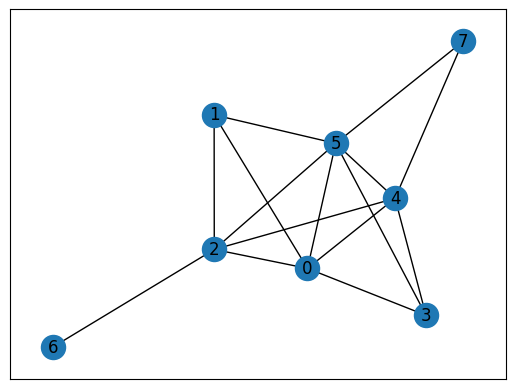

In [7]:
# independent inputs
NumberOfVerticies = 8
RootLambda = 1/3 # ratio of good states to all states
P_L = 0.9
ShotNumber = 1
BetaGrid = 5
GammaGrid = 5

# from the input we compute the following
delta = np.sqrt(1 - P_L)
l = int(np.ceil(np.arccosh(1/delta) / np.arccosh(1/np.sqrt(1 - RootLambda*RootLambda)))) // 2

# create large, random graph
GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
for i in range(NumberOfVerticies):
    for j in range(i + 1, NumberOfVerticies):
        if np.random.randint(0, 2) == 1:
            GraphLaplacian[i][j] = GraphLaplacian[j][i] = - 1
    GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])

NumberOfComponents = NumberOfVerticies - np.linalg.matrix_rank(GraphLaplacian)
    
print("the graph (number of components =",str(NumberOfComponents) + ")")
createGraph(GraphLaplacian)
           
NumberOfEdges = np.trace(GraphLaplacian) // 2

y = (4*NumberOfVerticies + int(np.sqrt(8*NumberOfVerticies + 1) - 1)) // 8 if NumberOfComponents == 1 else (2*NumberOfVerticies + NumberOfEdges - 1) // 4 # one less then the Erdos-Edwards bound
digits = int(np.ceil(np.log2(NumberOfEdges))) + 1 # + 1 for the sign

### results: naive bang-bang optimization with $p = 1$

In [8]:
print("\nthe graph Laplacian:\n")
print(GraphLaplacian.view(),"\n")
print("number of components\t=",NumberOfComponents,"\n")
print("cut threshold\t\t=",y)
print("Grover query complexity\t=",l)
print("square root of lambda\t=",RootLambda)
print("P_L\t\t\t=",P_L * 100,"%")
print("BetaGrid\t\t=",BetaGrid)
print("GammaGrid\t\t=",GammaGrid,"\n")

configurations, MaxCut = [], 0

step, total_step = 0, BetaGrid * GammaGrid

for i in range(BetaGrid):
    for j in range(GammaGrid):
            counts = GroverQAOACircuit(GraphLaplacian, digits, y, delta, l, [[np.pi * i / BetaGrid, 2 * np.pi * j / GammaGrid]], 1)
            if counts[0][1] >= MaxCut:
                if counts[0][1] > MaxCut:
                    configurations = [[counts[0][0], [np.pi * i / BetaGrid, 2 * np.pi * j / GammaGrid]]]
                    MaxCut = counts[0][1]
                else:
                    configurations.append([counts[0][0], [np.pi * i / BetaGrid, 2 * np.pi * j / GammaGrid]])
            step += 1
            print("progess = " + str(int(step * 100 / total_step)) + "%")

print("\nMaxCut =",MaxCut,"\n")
print("configurations:\n")
for conf in configurations:
    print("x\t=",conf[0].view(),"\nangles\t=",conf[1],"\n")
print()


the graph Laplacian:

[[ 5 -1 -1 -1 -1 -1  0  0]
 [-1  3 -1  0  0 -1  0  0]
 [-1 -1  5  0 -1 -1 -1  0]
 [-1  0  0  3 -1 -1  0  0]
 [-1  0 -1 -1  5 -1  0 -1]
 [-1 -1 -1 -1 -1  6  0 -1]
 [ 0  0 -1  0  0  0  1  0]
 [ 0  0  0  0 -1 -1  0  2]] 

number of components	= 1 

cut threshold		= 4
Grover query complexity	= 3
square root of lambda	= 0.3333333333333333
P_L			= 90.0 %
BetaGrid		= 5
GammaGrid		= 5 

progess = 4%
progess = 8%
progess = 12%
progess = 16%
progess = 20%
progess = 24%
progess = 28%
progess = 32%
progess = 36%
progess = 40%
progess = 44%
progess = 48%
progess = 52%
progess = 56%
progess = 60%
progess = 64%
progess = 68%
progess = 72%
progess = 76%
progess = 80%
progess = 84%
progess = 88%
progess = 92%
progess = 96%
progess = 100%

MaxCut = 11 

configurations:

x	= [1 0 0 0 1 1 1 0] 
angles	= [1.8849555921538759, 5.026548245743669] 


